# 20240422
Sarah Fong
- preprocessed Fimo predictions w 
        
        /$HOME/EMF/US/bin/features-FIMO-TFBS_make_max_score_pval_tables.ipynb

In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import gc_fraction

import config_readwrite as crw
import glob

import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd

from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from plot_params import fonts

In [2]:
CL = "hepg2"

In [3]:
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

section = "mpra"
FASTA = config[section]["fasta"]
MPRA = config[section][f"{CL}.clean.transformed"]
BUILD = "hg38"

section = "FIMO"
crw.check(config, section)
FIMO_PATH = "/wynton/home/ahituv/fongsl/EMF/US/data/fimo"#config[section]["path"]
FIMO_PRED = os.path.join(FIMO_PATH, "fimo.txt")#config[section]["pred"]
FIMO_MOTIF_MAX = os.path.join(FIMO_PATH, "fimo_motif.max_score.tsv.gz")

FIMO_MOTIF_MAX_TABLE = os.path.join(FIMO_PATH, "fimo_motif.max_score_table.tsv.gz")
FIMO_MOTIF_MAX_PTABLE = os.path.join(FIMO_PATH, "fimo_motif.max_score_pvalue.table.tsv.gz")

SYNTHETICS_PATH = "/wynton/home/ahituv/fongsl/EMF/US/results/mpra/eda/synthetics"
SYNTHETICS_MPRA = os.path.join(SYNTHETICS_PATH, f"synthetic.elements.in.{CL}.mpra.tsv")


# write
config[section]["max_score"]= FIMO_MOTIF_MAX
config[section]["max_score_table"]= FIMO_MOTIF_MAX_TABLE
config[section]["max_score_pval_table"]= FIMO_MOTIF_MAX_PTABLE

section = "SYNTHETICS"
crw.check(config, section)

config[section]["path"]= SYNTHETICS_PATH
config[section][f"mpra.{CL}"] = SYNTHETICS_MPRA
crw.write(config, cfn)


# set up fimo + jaspar run

In [4]:
def runFimo(input_file, build, config):
    
    FIMO = os.path.join(os.environ["HOME"], "tools", "genome", "fimo.sh") # .py if you want to run in cmd line
    if os.path.exists(config) is False:
        empty_config = os.path.join(os.getcwd(), "config.ini")
        os.system(f"touch {empty_config}")
    
    cmd = " ".join([
        "qsub", 
        FIMO,
        input_file,
        f"-c {config}",
        f"-g {build}"
    ])
    print("running fimo", cmd)
    os.system(cmd)

## run

In [5]:
if os.path.exists(FIMO_PRED) is False:
    runFimo(FASTA, BUILD, cfn)

# GC content 

In [7]:
gc = {}
with open(FASTA) as handle:

    for values in SimpleFastaParser(handle):
        name, seq = values
        gc[name]=gc_fraction(seq)


In [8]:
# make a dataframe of GC values for the entire MPRA library
gcdf = pd.DataFrame(gc.items())
gcdf.columns=["name", "gc"]  # rename columns

gcdf.head()

,name,gc
0,bj_k27ac_down_chr3:29837526-29837795,0.281481
1,bj_k27ac_down_chr3:29837260-29837529,0.281481
2,bj_k27ac_down_chr3:29837792-29838061,0.355556
3,bj_k27ac_down_chr3:29837392-29837661,0.303704
4,bj_k27ac_down_chr3:29837659-29837928,0.311111


<Axes: xlabel='gc', ylabel='Count'>

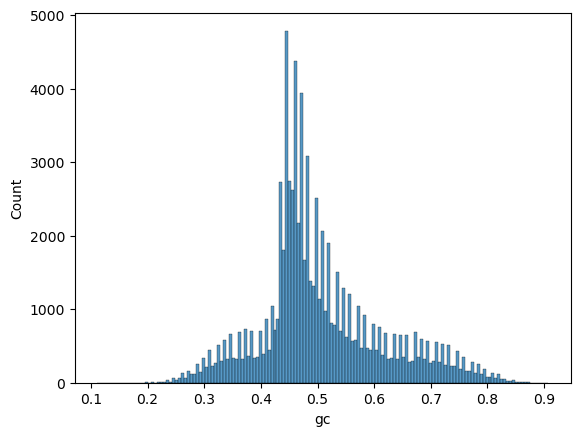

In [9]:
# histplot of % GC
sns.histplot(gcdf["gc"])

# MPRA ~ GC

In [10]:
df = pd.read_csv(MPRA, sep='\t',)
df

,seq.id,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,...,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean
0,seq.0,BJ_down-DEG-prom_ENSG00000258064_chr12:7167269...,Promoter_DEG,1.070365,0,1.107709,1.062185,1.041201,1.083715,0,...,0.138128,0.101153,0.087035,0.097621,0.045596,0.108409,0.115896,0.019592,0.021374,0.018276
1,seq.1,BJ_down-DEG-prom_ENSG00000258064_chr12:7167293...,Promoter_DEG,1.127867,0,1.121452,1.154453,1.107696,1.119848,0,...,0.176313,0.136387,0.165367,0.173380,0.030620,0.176313,0.163178,0.023204,0.010945,-0.010201
2,seq.2,BJ_down-DEG-prom_ENSG00000258064_chr12:7167318...,Promoter_DEG,1.045273,0,1.060571,1.040215,1.035032,1.046512,0,...,0.049738,0.063808,0.056882,0.063799,0.018576,0.063808,0.065525,0.016711,0.006926,0.001725
3,seq.3,BJ_down-DEG-prom_ENSG00000258064_chr12:7167342...,Promoter_DEG,1.388219,1,1.431877,1.349455,1.383327,1.418199,1,...,0.536480,0.474277,0.468142,0.472809,0.042956,0.500746,0.503834,0.031216,0.032604,0.031026
4,seq.4,BJ_down-DEG-prom_ENSG00000258064_chr12:7167367...,Promoter_DEG,1.098010,0,1.121973,1.074758,1.097298,1.103948,0,...,0.127767,0.095960,0.133955,0.134668,0.031019,0.127767,0.141982,0.054537,-0.006189,0.007313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58612,seq.82411,k562_k27ac_up_chr9:129402570-129402839,Differential_H3K27ac,0.617967,0,0.577024,0.583477,0.693402,0.684918,0,...,-0.552846,-0.666423,-0.777253,-0.699596,0.148618,-0.552846,-0.549269,0.118982,0.224407,0.150326
58613,seq.82417,k562_k27ac_up_chrX:154123331-154123600,Differential_H3K27ac,1.118351,0,1.562728,0.924180,0.868144,1.154907,0,...,0.044281,0.049939,-0.113753,0.108773,0.465769,0.049939,0.192641,0.252084,0.163692,0.083868
58614,seq.82418,k562_k27ac_up_chrX:154123463-154123732,Differential_H3K27ac,0.963361,0,0.911258,1.057504,0.921321,0.938231,0,...,0.018573,-0.014789,-0.118224,-0.057210,0.119664,-0.014789,-0.098928,0.175419,0.103435,-0.041718
58615,seq.82421,k562_k27ac_up_chrX:154123863-154124132,Differential_H3K27ac,0.911969,0,0.897749,1.138903,0.699253,0.776374,0,...,-0.027868,-0.426472,-0.155616,-0.161361,0.351914,-0.426472,-0.393769,0.350695,-0.270856,-0.232408


## Merge MPRA w GC data

In [11]:
m = pd.merge(df, gcdf)

In [12]:
# count of names in merge of MPRA + GC 
m.groupby(["label"])['name'].count()

label
Differential_ATAC       11432
Differential_H3K27ac    14617
NegCtl_Ilias_MPRA          54
NegCtl_Vikram_MPRA         93
Non-differential          117
PosCtk_Vikram_MPRA         70
PosCtl_Ilias_MPRA          58
PosCtl_bj_luciferase       18
Promoter_DEG              235
Shuffle                   304
Synthetic               31619
Name: name, dtype: int64

In [13]:
pipe = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])

X = np.vstack(m["gc"])
y = np.vstack(m["logFC"])

pipe.fit(X, y)

print(pipe.score(X, y))

reg = pipe.named_steps["reg"]

7.494243969508041e-06


## GC content is significantly associated with log2FC in activity, but effect is slight
- r2 = 7.494243969508041e-06, coeff = -0.00028356

# synthetics 
- some HepG2 hypotheses from ./EMF/US/synthetics.ipynb indicate that position 50-100 is the most US sensitive. 
    - US increase: CCCCTCCCCC pos 57, TGTAACAA pos 17

    - US decrease: TAATT pos1, TTTTATAA pos 41
    - both us increase and decrease: CGCCACGGCGGGGGTGGAGGA pos 57, GAGGGGTCTT  pos 65, 
    
- Evaluate motifs of entire element when synthetic sequence is added. 

In [14]:
syn = pd.read_csv(SYNTHETICS_MPRA, sep='\t')
syn.head()

,pos,motif,shuf,seq,insert_type,n_inserts,motif_len,name
0,1,CCAGGAACAG,False,SYNTHETIC:_The_motif_CCAGGAACAG_was_added_in_P...,single,1,10,SYNTHETIC:_The_motif_CCAGGAACAG_was_added_in_P...
1,1,CTGTTCCTGG,False,SYNTHETIC:_The_motif_CTGTTCCTGG_was_added_in_P...,single,1,10,SYNTHETIC:_The_motif_CTGTTCCTGG_was_added_in_P...
2,9,CCAGGAACAG,False,SYNTHETIC:_The_motif_CCAGGAACAG_was_added_in_P...,single,1,10,SYNTHETIC:_The_motif_CCAGGAACAG_was_added_in_P...
3,9,CTGTTCCTGG,False,SYNTHETIC:_The_motif_CTGTTCCTGG_was_added_in_P...,single,1,10,SYNTHETIC:_The_motif_CTGTTCCTGG_was_added_in_P...
4,17,CCAGGAACAG,False,SYNTHETIC:_The_motif_CCAGGAACAG_was_added_in_P...,single,1,10,SYNTHETIC:_The_motif_CCAGGAACAG_was_added_in_P...


In [15]:
MOTIFS = [("CCCCTCCCCC", 57), 
          ("TGTAACAA", 17), 
          ("TAATT", 1),
          ("TTTTATAA", 41), 
          ("CGCCACGGCGGGGGTGGAGGA", 57), 
          ("GAGGGGTCTT", 65)
         ]
MOTIF, POS = MOTIFS[0]

SINGLE = f"SYNTHETIC:_The_motif_{MOTIF}_was_added_in_Pos:{POS}"

# all MPRA motifs sequences with this motif + position
MOTIF_SEQS = syn.loc[(syn["motif"]==MOTIF)&
       (syn["pos"]==POS), 'seq']  

# both het and homo synthetic sequences
MPRA_SEQS = m.loc[(m['name'].isin(MOTIF_SEQS)), "name"].unique()  # get the sequences that have been tested in MPRA. 


POSITIONS = syn.loc[(syn["motif"] == MOTIF) &
                    (syn['insert_type'] == "single"),
                    "pos"
                    ].to_list() # list of all the positions for a single motif

# One motif insertion

## split FIMO predictions per motif

In [16]:
fs = glob.glob(os.path.join(FIMO_PATH, "MA*.txt"))

## get motif names

In [17]:
# 
NAMES_FILE = os.path.join(FIMO_PATH, "motif_id.txt")
NAMES = list(pd.read_csv(NAMES_FILE, sep='\t'))

KEEP_COLS = [["motif_alt_id",
              'motif_id',
             'sequence_name',
             'score',
             'p-value',
             'matched_sequence'
             ]]

## grep motifs for each element

In [18]:
os.chdir(FIMO_PATH)

In [19]:
# ONE MOTIF, ALL SINGLE_INSERTION POSITIONS
# make outdir
RE = os.path.join(FIMO_PATH, f"syn_single_insert_{MOTIF}")

if os.path.exists(RE) is False:
    os.mkdir(RE)

preds = {}
for n, pos in enumerate(POSITIONS):

    name = f"SYNTHETIC:_The_motif_{MOTIF}_was_added_in_Pos:{pos}"
    out = os.path.join(RE, f"pos_{pos}.{MOTIF}.txt")

    cmd = " ".join(["grep -w",  # -
                    name,
                    "MA*.txt >",
                    out
                    ])
    if os.path.exists(out) is False:
        print("pos", pos)
        os.system(cmd)

    # read dataframe
    results = pd.read_csv(out, sep='\t', header=None, names=NAMES)
    results["insertion_pos"] = pos  # annotate insertion position

    preds[pos] = results

## make background sequence

In [25]:
def getbkgd(pos, motif):
    """return motifs in background - inside and outside insertion
        return motifs created by insertion
    """
    print(pos)
    posdf = preds[pos]
    bkgd_ins = preds[89]

    # get motifs predicted around insertion site
    bkgdg_outside_ins = posdf.loc[(posdf["start"] > (pos+len(motif))) |
                                  (posdf["stop"] < pos)
                                  ]

    # get motifs predicted at insertion site using a different insertion dataset
    bkgdg_inside_ins = bkgd_ins.loc[(bkgd_ins["start"] <= (pos+len(motif))) &
                                    (bkgd_ins["start"] >= (pos))
                                    ]

    # get motifs predicted at insertion site using a different insertion dataset
    print("foreground start is less than", pos+len(motif), "more than", pos)

    foregd = posdf.loc[(posdf["start"] <= (pos+len(motif))) &
                       (posdf["start"] >= (pos))
                       ]

    fullbkgd = pd.concat([bkgdg_inside_ins, bkgdg_outside_ins]).sort_values(
        by=["start", "stop"]).drop_duplicates()

    print(bkgdg_inside_ins.shape[0], bkgdg_outside_ins.shape[0],
          fullbkgd.shape[0], foregd.shape[0])

    return bkgdg_outside_ins, bkgdg_inside_ins, foregd


def roundCoor(df_):
    """ round start, stop coordinates to the nearest 10bp, keep strand
        FILTER - pick the motif with the highest p-value in that segment
    """
    df = df_.copy()
    # round start, stop
    if "start_r" not in list(df):

        
        # round to the nearest 10bp
        df['start_r'] = df["start"].round(-1)
        df['stop_r'] = df["stop"].round(-1)

    # FILTER - summarize motifs for each bin by MOST SIGNIFICANT P-VALUE
    grouped = df.groupby(['start_r', "stop_r", "strand"])[
        "p-value"].min().reset_index()

    # keep only most significant id, add back motif_alt_id
    grouped = pd.merge(grouped, df[[
                       'start_r', "stop_r", "strand", "p-value", "motif_alt_id"]]).drop_duplicates()

    return df, grouped


def plotLineGraph(df, color):
    """
    plot line graph of motifs
    """
    # plot background
    v = 0
    data = df.sort_values(by="p-value")
    # plot the top X motifs (based on q-value, which is biased by motif len)
    PLOT_TOP = data.shape[0]
    for n, row in data.iterrows():
        if row["start_r"] != row["stop_r"]:
            X = [row["start_r"], row["stop_r"]]
        else:
            X = [row["start_r"], row["stop_r"]+10]

        if row["strand"] == "-":  # put negative strand ranks underneath the position
            n = -n

        y = [n, n]

        label = row["motif_alt_id"]  # " ".join(row["motif_alt_id"])
        # print(label, type(label), type(X), type(y))
        v += 1
        plt.plot(X, y, lw=3, color=color, alpha=0.3)
        plt.annotate(label, (X[0], y[0]), color=color)
        
        if v == PLOT_TOP:
            plt.axhline(0, ls="--", color=color)
            plt.ylabel("p-val rank")
            plt.xlabel("pos")
        plt.xlim(0, 270)

In [30]:
lastf1, lastkin = set(), set()
for key in preds.keys():
    
    print(key)
    kout, kin, f1= getbkgd(key, MOTIF)

    f1, groupedf1 = roundCoor(f1) # round the forground

    kout, groupedkout = roundCoor(kout) # round the background

    kin, groupedkin = roundCoor(kin) # round the background

    # plot
    """
    plotLineGraph(groupedkout, "grey")
    plt.title(f"pos {key}, {MOTIF}")
    plt.show()
    
    plotLineGraph(groupedkin, "red")
    plt.show()
    plotLineGraph(groupedf1, "black")
    
    plt.title(f"pos {key}, {MOTIF}")
    plt.show()
    """
    
    currentf1, currentkin=set(groupedf1["motif_alt_id"]), set(groupedkin["motif_alt_id"])

    print("dif lost", currentkin.difference(lastkin), "\ncurrent/last lost", currentkin, lastkin, "\n",  "\n", ) # compare motifs that have been lost by insertion v last insertion
    print("dif gained", currentf1.difference(lastf1), "\ncurrent/last gain",  currentf1, lastf1, "\n",  "\n", ) # compare motifs created by insertion v last insertion
    
    lastf1, lastkin =  currentf1, currentkin
    

    if key==57:
        break

1
1
foreground start is less than 11 more than 1
1 61 62 15
dif lost {'ETV2::FOXI1'} 
current/last lost {'ETV2::FOXI1'} set() 
 

dif gained {'msn-1', 'Wt1', 'SP5', 'PATZ1'} 
current/last gain {'msn-1', 'Wt1', 'SP5', 'PATZ1'} set() 
 

9
9
foreground start is less than 19 more than 9
1 60 61 21
dif lost {'WRKY46'} 
current/last lost {'WRKY46'} {'ETV2::FOXI1'} 
 

dif gained {'ARF14', 'Znf423'} 
current/last gain {'ARF14', 'SP5', 'PATZ1', 'Znf423'} {'msn-1', 'Wt1', 'SP5', 'PATZ1'} 
 

17
17
foreground start is less than 27 more than 17
6 54 60 13
dif lost {'ZBTB26', 'Hand1::Tcf3', 'Smad4', 'sma-4', 'SMAD2'} 
current/last lost {'ZBTB26', 'Hand1::Tcf3', 'Smad4', 'sma-4', 'SMAD2'} {'WRKY46'} 
 

dif gained set() 
current/last gain {'SP5', 'PATZ1'} {'ARF14', 'SP5', 'PATZ1', 'Znf423'} 
 

25
25
foreground start is less than 35 more than 25
4 54 58 13
dif lost {'ZNF528'} 
current/last lost {'Smad4', 'Hand1::Tcf3', 'ZNF528', 'SMAD2'} {'ZBTB26', 'Hand1::Tcf3', 'Smad4', 'sma-4', 'SMAD2'} 
 

dif

# figure out how to make sense of gains and losses. 